# Forecasting prices

## Overview

Train several models to see what's the better performance.

Models:

* KNN
* ARIMA Model
* Bagging
* Boosting

## Import libraries

In [19]:
import sys
!{sys.executable} -m  conda install -c anaconda scikit-learn

Solving environment: done

# All requested packages already installed.



In [28]:
import datetime as dt
import os
import pandas as pd
import numpy as np
import csv
import warnings

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# ARIMA
from statsmodels.tsa.arima_model import ARIMA

#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Neural Network
from sklearn.neural_network import MLPClassifier


# Add plotly for interactive charts
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools



## Initial variables

In [3]:
symbol = "AABA"

## Reading data from CSV file

In [4]:
# Get values from cvs file
filename = "data/" + symbol + ".csv"
headers = ["date", symbol]
portf_value = pd.read_csv(filename, sep=",", names = headers)
portf_value.set_index("date", inplace= True)

In [5]:
# Normalize the prices Dataframe
normed = portf_value.copy()

In [6]:
# Convert price column to float
normed[symbol] = pd.to_numeric(normed[symbol], errors='coerce').fillna(0)

In [7]:
normed.info()
normed.head()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, date to 2019-01-11
Data columns (total 1 columns):
AABA    126 non-null float64
dtypes: float64(1)
memory usage: 2.0+ KB


,AABA
date,
date,0.000000
2018-07-16,74.660004
2018-07-17,75.360001
2018-07-18,74.660004
2018-07-19,73.360001


## Getting indicator values

In [8]:
# Momentum
price = normed[symbol]
window = 10
momentum = pd.Series(np.nan, index=price.index)
momentum.iloc[window:] = (price.iloc[window:] / price.values[:-window]) - 1


In [9]:
# Rolling Mean
rolling_mean = price.rolling(window).mean()

In [10]:
# SMA
sma = price / rolling_mean - 1

In [11]:
# RSI
def get_RSI(prices, n=14):
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>=0].sum()/n
    down = -seed[seed<0].sum()/n
    rs = up/down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100./(1.+rs)

    for i in range(n, len(prices)):
        delta = deltas[i-1] # cause the diff is 1 shorter
        if delta>0:
            upval = delta
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        up = (up*(n-1) + upval)/n
        down = (down*(n-1) + downval)/n
        rs = up/down
        rsi[i] = 100. - 100./(1.+rs)
    return rsi

rsi = get_RSI(price)

# Clean nan values
normed = normed.fillna(0)

# Sort dataframe by index
normed.sort_index()



,AABA
date,
2018-07-16,74.660004
2018-07-17,75.360001
2018-07-18,74.660004
2018-07-19,73.360001
2018-07-20,73.269997
2018-07-23,73.150002
2018-07-24,74.150002
2018-07-25,77.529999
2018-07-26,76.190002


## Create dataframe indicators columns

In [12]:
# Create momentum column
normed['Momentum'] = momentum

# Create SMA column
normed['SMA'] = sma

# Create SMA column
normed['RSI'] = rsi


# Sort dataframe by index
normed.sort_index()

# Clean nan values
normed = normed.fillna(0)

normed.head()



,AABA,Momentum,SMA,RSI
date,,,,
date,0.000000,0.0,0.0,89.757837
2018-07-16,74.660004,0.0,0.0,89.757837
2018-07-17,75.360001,0.0,0.0,89.757837
2018-07-18,74.660004,0.0,0.0,89.757837
2018-07-19,73.360001,0.0,0.0,89.757837


In [13]:

#missing data
total = normed.isnull().sum().sort_values(ascending=False)
percent = (normed.isnull().sum()/normed.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)
print(missing_data)



          Total  Percent
RSI           0      0.0
SMA           0      0.0
Momentum      0      0.0
AABA          0      0.0


## Correlation matrix

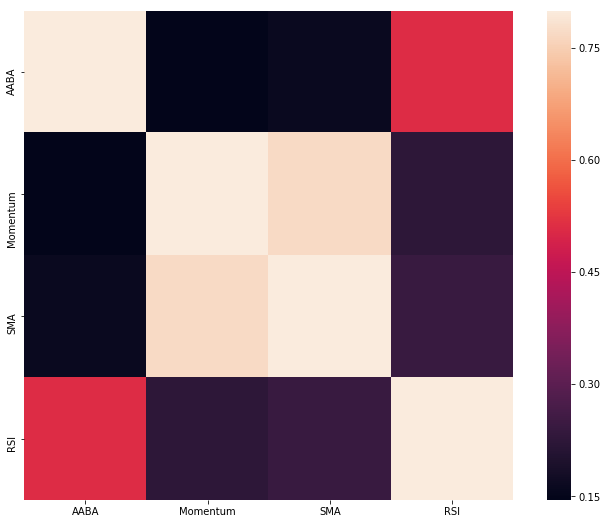

/home/emi/miniconda3py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2320: RuntimeWarning:

invalid value encountered in subtract



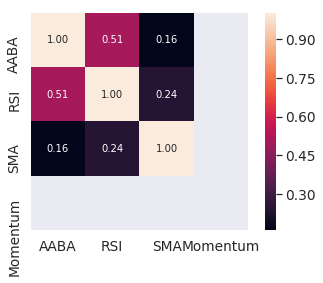

In [14]:
#correlation matrix
corrmat = normed.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);
plt.show()

#treatment correlation matrix
k = 4 #number of variables for heatmap
cols = corrmat.nlargest(k, symbol)[symbol].index
cm = np.corrcoef(normed[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

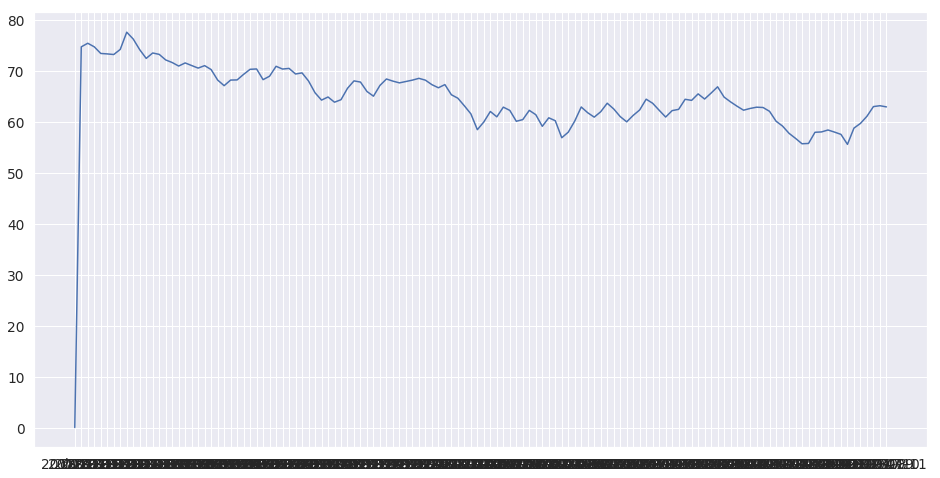

In [15]:

#plot
plt.figure(figsize=(16,8))
plt.plot(normed[symbol], label='Adj. Close Price history')

## Splitting the dataset

In [16]:
# Define X and y
feature_cols = ['Momentum', 'SMA']
X = normed[feature_cols]
y = normed[symbol]
sc_y = StandardScaler()
y = np.array(y).reshape(-1,1)
y = sc_y.fit_transform(y)

print('X matrix dimensionality:', X.shape)
print('Y vector dimensionality:', y.shape)

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=False)


X matrix dimensionality: (126, 2)
Y vector dimensionality: (126, 1)


# Evaluating models

## KNeighbors Regressor

### Hyperparameter optimization

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

hyper_params = [x for x in range(1,21)]
mse_values = []
for h in hyper_params:
    knn = KNeighborsRegressor(n_neighbors = h, algorithm = 'auto')
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    mse_values.append(mean_squared_error(y_test, predictions))
    print("Neighbors ", h, "MSE ", mse_values[h-1])


In [ ]:
plt.his(hyper_params, mse_values)
plt.show()

## ARIMA Model

In [25]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [26]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [29]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=24.927
ARIMA(0, 0, 1) MSE=8.214
ARIMA(0, 0, 2) MSE=3.401
ARIMA(0, 1, 0) MSE=2.031
ARIMA(0, 1, 1) MSE=2.239
ARIMA(0, 1, 2) MSE=4.172
ARIMA(0, 2, 0) MSE=3.202
ARIMA(0, 2, 1) MSE=3.383
ARIMA(0, 2, 2) MSE=2.942
ARIMA(1, 0, 0) MSE=2.588
ARIMA(1, 0, 1) MSE=3.160
ARIMA(1, 0, 2) MSE=2.753
ARIMA(1, 1, 0) MSE=2.102
ARIMA(1, 2, 0) MSE=3.335
ARIMA(2, 1, 0) MSE=2.309
ARIMA(2, 2, 0) MSE=3.411
ARIMA(2, 2, 1) MSE=4.181
ARIMA(4, 0, 0) MSE=2.563
ARIMA(4, 1, 0) MSE=2.153
ARIMA(4, 1, 1) MSE=2.472
ARIMA(4, 2, 0) MSE=3.086
ARIMA(6, 0, 1) MSE=3.108
ARIMA(6, 1, 0) MSE=2.195
ARIMA(6, 1, 1) MSE=2.191
ARIMA(6, 1, 2) MSE=5.428
ARIMA(6, 2, 0) MSE=2.765
ARIMA(8, 0, 0) MSE=2.999
ARIMA(8, 0, 1) MSE=2.978
ARIMA(8, 0, 2) MSE=3.097
ARIMA(8, 1, 0) MSE=3.076
ARIMA(8, 1, 1) MSE=3.148
ARIMA(8, 1, 2) MSE=3.849
ARIMA(8, 2, 0) MSE=4.572
ARIMA(10, 0, 0) MSE=3.076
ARIMA(10, 1, 0) MSE=3.137
ARIMA(10, 1, 1) MSE=3.352
ARIMA(10, 2, 0) MSE=5.501
Best ARIMA(0, 1, 0) MSE=2.031


predicted=64.375608, expected=62.480000
predicted=63.232771, expected=60.980000
predicted=61.705952, expected=59.950001
predicted=60.655295, expected=61.209999
predicted=61.921743, expected=62.279999
predicted=62.995861, expected=64.389999
predicted=65.121704, expected=63.590000
predicted=64.304494, expected=62.220001
predicted=62.911334, expected=60.889999
predicted=61.559120, expected=62.150002
predicted=62.825546, expected=62.400002
predicted=63.070970, expected=64.370003
predicted=65.054790, expected=64.160004
predicted=64.835372, expected=65.430000
predicted=66.111563, expected=64.419998
predicted=65.084122, expected=65.589996
predicted=66.259282, expected=66.820000
predicted=67.494949, expected=64.800003
predicted=65.448003, expected=63.860001
predicted=64.492278, expected=63.009998
predicted=63.627743, expected=62.230000
predicted=62.834175, expected=62.570000
predicted=63.171635, expected=62.820000
predicted=63.418286, expected=62.759998
predicted=63.352073, expected=62.009998


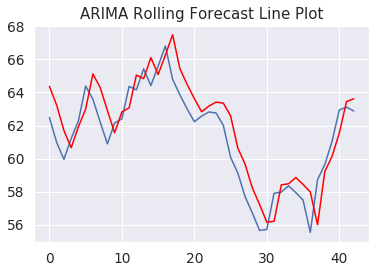

In [30]:

from pandas import Series
series =  pd.Series(normed[symbol].values)

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.title("ARIMA Rolling Forecast Line Plot")
plt.show()